In [366]:
import torch
from d2l import torch as d2l

before we can use stochastic gradient descent (SGD), we need to define some inital parameters for our model. 

here, we initialise some random weights from a normal distribution of mean 0 and standard deviation 0.01. we also set bias to 0. 

In [367]:
n_inputs = 10
w = torch.normal(0, 0.01, (n_inputs, 1), requires_grad=True)
w

tensor([[-0.0044],
        [-0.0017],
        [ 0.0115],
        [ 0.0101],
        [-0.0093],
        [-0.0058],
        [ 0.0194],
        [-0.0221],
        [ 0.0003],
        [-0.0023]], requires_grad=True)

In [368]:
b = torch.zeros(1, requires_grad=True)
b

tensor([0.], requires_grad=True)

In [369]:
class LinearRegressionScratch(d2l.Module):  #@save
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        with torch.no_grad():
            self.w[0] = 1000
        #self.w = torch.zeros(num_inputs, 1, requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)

then we define our model. for this linear model we just take the matrix-vector product of input features 'X' and model weights 'w' and add bias 'b'. 

essentially:
return Xw + b

where b is added to every component of the vector Xw. 

In [370]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def forward(self, X):
    return torch.matmul(X, self.w) + self.b 

now we define the loss function. we use squared loss function

we need to transform the true value y into the predicted value’s shape y_hat. The result returned by the following method will also have the same shape as y_hat. We also return the averaged loss value among all examples in the minibatch.

In [371]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2 # mse loss
    
    #l = (y_hat - d2l.reshape(y, y_hat.shape)).abs().sum() # absolute value loss
    #delta = 1
    #l = torch.where(torch.abs(y_hat - y) < delta, 0.5 * (y_hat - y)**2, delta * (torch.abs(y_hat - y) - 0.5 * delta)).mean() # huber loss
    l = l.mean()
    return l

we gonna use minibatch sgd for the optimisation 

at each step, use a random minibatch from the dataset, then estimate the gradient of the loss w.r.t. the parameters. then update the parameters to reduce loss.

The following code applies the update, given a set of parameters, a learning rate lr. Since our loss is computed as an average over the minibatch, we do not need to adjust the learning rate against the batch size. In later chapters we will investigate how learning rates should be adjusted for very large minibatches as they arise in distributed large-scale learning. For now, we can ignore this dependency.

In [372]:
class SGD(d2l.HyperParameters):  #@save
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [373]:
@d2l.add_to_class(LinearRegressionScratch)  #@save
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

In each epoch, we iterate through the entire training dataset, passing once through every example (assuming that the number of examples is divisible by the batch size). 

In each iteration, we grab a minibatch of training examples, and compute its loss through the model’s training_step method. 

Then we compute the gradients with respect to each parameter. Finally, we will call the optimization algorithm to update the model parameters. In summary, we will execute the following loop:

1. Initialize parameters <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mo stretchy="false">(</mo>
  <mrow data-mjx-texclass="ORD">
    <mi mathvariant="bold">w</mi>
  </mrow>
  <mo>,</mo>
  <mi>b</mi>
  <mo stretchy="false">)</mo>
</math>

2. Repeat until done
    - Compute gradient <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mrow data-mjx-texclass="ORD">
    <mi mathvariant="bold">g</mi>
  </mrow>
  <mo stretchy="false">&#x2190;</mo>
  <msub>
    <mi>&#x2202;</mi>
    <mrow data-mjx-texclass="ORD">
      <mo stretchy="false">(</mo>
      <mrow data-mjx-texclass="ORD">
        <mi mathvariant="bold">w</mi>
      </mrow>
      <mo>,</mo>
      <mi>b</mi>
      <mo stretchy="false">)</mo>
    </mrow>
  </msub>
  <mfrac>
    <mn>1</mn>
    <mrow>
      <mo stretchy="false">|</mo>
      <mrow data-mjx-texclass="ORD">
        <mi data-mjx-variant="-tex-calligraphic" mathvariant="script">B</mi>
      </mrow>
      <mo stretchy="false">|</mo>
    </mrow>
  </mfrac>
  <munder>
    <mo data-mjx-texclass="OP">&#x2211;</mo>
    <mrow data-mjx-texclass="ORD">
      <mi>i</mi>
      <mo>&#x2208;</mo>
      <mrow data-mjx-texclass="ORD">
        <mi data-mjx-variant="-tex-calligraphic" mathvariant="script">B</mi>
      </mrow>
    </mrow>
  </munder>
  <mi>l</mi>
  <mo stretchy="false">(</mo>
  <msup>
    <mrow data-mjx-texclass="ORD">
      <mi mathvariant="bold">x</mi>
    </mrow>
    <mrow data-mjx-texclass="ORD">
      <mo stretchy="false">(</mo>
      <mi>i</mi>
      <mo stretchy="false">)</mo>
    </mrow>
  </msup>
  <mo>,</mo>
  <msup>
    <mi>y</mi>
    <mrow data-mjx-texclass="ORD">
      <mo stretchy="false">(</mo>
      <mi>i</mi>
      <mo stretchy="false">)</mo>
    </mrow>
  </msup>
  <mo>,</mo>
  <mrow data-mjx-texclass="ORD">
    <mi mathvariant="bold">w</mi>
  </mrow>
  <mo>,</mo>
  <mi>b</mi>
  <mo stretchy="false">)</mo>
</math>
    - Update parameters <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mo stretchy="false">(</mo>
  <mrow data-mjx-texclass="ORD">
    <mi mathvariant="bold">w</mi>
  </mrow>
  <mo>,</mo>
  <mi>b</mi>
  <mo stretchy="false">)</mo>
  <mo stretchy="false">&#x2190;</mo>
  <mo stretchy="false">(</mo>
  <mrow data-mjx-texclass="ORD">
    <mi mathvariant="bold">w</mi>
  </mrow>
  <mo>,</mo>
  <mi>b</mi>
  <mo stretchy="false">)</mo>
  <mo>&#x2212;</mo>
  <mi>&#x3B7;</mi>
  <mrow data-mjx-texclass="ORD">
    <mi mathvariant="bold">g</mi>
  </mrow>
</math>

In [374]:
@d2l.add_to_class(d2l.Trainer)  #@save
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)  #@save
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

We are almost ready to train the model, but first we need some training data. Here we use the SyntheticRegressionData class and pass in some ground truth parameters. Then we train our model with the learning rate lr=0.03 and set max_epochs=3. Note that in general, both the number of epochs and the learning rate are hyperparameters. In general, setting hyperparameters is tricky and we will usually want to use a three-way split, one set for training, a second for hyperparameter selection, and the third reserved for the final evaluation. We elide these details for now but will revise them later.

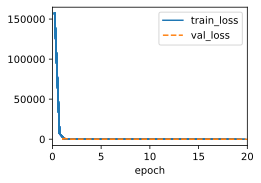

In [375]:
model = LinearRegressionScratch(2, lr=0.1)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=20)
trainer.fit(model, data)

In [376]:
with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([1.7273e-04, 5.9843e-05])
error in estimating b: tensor([0.0002])


<h1>3.4.6 Exercises</h1>

1. What would happen if we were to initialize the weights to zero. Would the algorithm still work? What if we initialized the parameters with variance 
1000 rather than 0.1
?

it still works if the weights were zero. this is because the loss function in linear regression only has one global minimum for gradient descent. in more complex models, this might not work, since if all neurons are initialised the same, it may cause the symmetry problem where all the neurons learn identical features. 

if we initialise the variance to 1000, the initial predictions have very high loss values. this may also cause gradients to be very big and cause huge learning shifts. but depending on the learning rate, it could be fine. in this scenario, a lr of 0.03 is good enough for the model to reach a decent value within 3 epochs. 

since linear regression is simple, it pretty much converges no matter what. these things would probably make deep learning algorithms not work. 

2. Assume that you are Georg Simon Ohm trying to come up with a model for resistance that relates voltage and current. Can you use automatic differentiation to learn the parameters of your model?

yes you could. you couse provide a dataset of voltage and current measurements. then use the model to find a parameters which relate voltage and current. then you could determine the relationship using the equation p = Xw + b where p is prediction, X is input, w is weight, and b is bias. we now know that ohm's law says V = IR. so p = V, X = I, and w would learn R and b would be 0 or close to 0.

3. Can you use Planck’s Law to determine the temperature of an object using spectral energy density? For reference, the spectral density 
<math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>B</mi>
</math> of radiation emanating from a black body is 
 <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>B</mi>
  <mo stretchy="false">(</mo>
  <mi>&#x3BB;</mi>
  <mo>,</mo>
  <mi>T</mi>
  <mo stretchy="false">)</mo>
  <mo>=</mo>
  <mfrac>
    <mrow>
      <mn>2</mn>
      <mi>h</mi>
      <msup>
        <mi>c</mi>
        <mn>2</mn>
      </msup>
    </mrow>
    <msup>
      <mi>&#x3BB;</mi>
      <mn>5</mn>
    </msup>
  </mfrac>
  <mo>&#x22C5;</mo>
  <msup>
    <mrow data-mjx-texclass="INNER">
      <mo data-mjx-texclass="OPEN">(</mo>
      <mi>exp</mi>
      <mo data-mjx-texclass="NONE">&#x2061;</mo>
      <mfrac>
        <mrow>
          <mi>h</mi>
          <mi>c</mi>
        </mrow>
        <mrow>
          <mi>&#x3BB;</mi>
          <mi>k</mi>
          <mi>T</mi>
        </mrow>
      </mfrac>
      <mo>&#x2212;</mo>
      <mn>1</mn>
      <mo data-mjx-texclass="CLOSE">)</mo>
    </mrow>
    <mrow data-mjx-texclass="ORD">
      <mo>&#x2212;</mo>
      <mn>1</mn>
    </mrow>
  </msup>
</math>
. Here <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>&#x3BB;</mi>
</math>
 is the wavelength, <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>T</mi>
</math>
 is the temperature, <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>c</mi>
</math>
 is the speed of light, <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>h</mi>
</math>
 is Planck’s constant, and <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>k</mi>
</math>
 is the Boltzmann constant. You measure the energy for different wavelengths <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mi>&#x3BB;</mi>
</math>
 and you now need to fit the spectral density curve to Planck’s law.

is this question asking to solve this using the linear regression model?

if so then no - due to the exp term, this isnt a linear relationship. so you can't model this using our model

4. What are the problems you might encounter if you wanted to compute the second derivatives of the loss? How would you fix them?

second derivatives might not always exist, and they are computationally expensive to calculate. this scales O(n^2). 

5. Why is the reshape method needed in the loss function?

we need to match the dimensions between prediction and target tensors so that it works. 

6. Experiment using different learning rates to find out how quickly the loss function value drops. Can you reduce the error by increasing the number of epochs of training?

when we set the lr really high it overshoots the minimum. sometimes it oscillates or even diverges at really large lr. 

error reduces by increasing epochs, but plateaus after a certain while. if lr is too large, it cannot fix it. 

7. If the number of examples cannot be divided by the batch size, what happens to data_iter at the end of an epoch?

the last batch would just contain the remainder of items. 

8. Try implementing a different loss function, such as the absolute value loss (y_hat - d2l.reshape(y, y_hat.shape)).abs().sum().

- Check what happens for regular data.

the loss is way higher compared to before

- Check whether there is a difference in behavior if you actively perturb some entries, such as <math xmlns="http://www.w3.org/1998/Math/MathML">
  <msub>
    <mi>y</mi>
    <mn>5</mn>
  </msub>
  <mo>=</mo>
  <mn>10000</mn>
</math>
, of <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mrow data-mjx-texclass="ORD">
    <mi mathvariant="bold">y</mi>
  </mrow>
</math>
.

with absolute value loss, the loss starts very high, then goes low, then still plateaus at a significant level. the original loss function is much better. works best around 0.1 lr

- Can you think of a cheap solution for combining the best aspects of squared loss and absolute value loss? Hint: how can you avoid really large gradient values?

i tried using huber loss - it works well, but not as well as the original one. it is much slower - requires much higher lr or else it oscillates.

9. Why do we need to reshuffle the dataset? Can you design a case where a maliciously constructed dataset would break the optimization algorithm otherwise?

Imagine you have a binary classification problem where your dataset consists of two classes: A and B. Now, suppose the dataset is maliciously ordered so that all examples from class A come first, followed by all examples from class B.

During training, the mini-batches in the first part of each epoch contain only class A samples. The model’s parameters are updated to favor class A predictions. Then, in the latter part of the epoch, when it sees only class B samples, the gradients swing dramatically in the opposite direction. This can lead to:

Oscillatory Updates: The model might keep shifting between favoring class A and class B, never settling on a good decision boundary.
Inefficient Learning: The model could take much longer to converge because each mini-batch provides a misleading picture of the overall data distribution.